In [77]:
import numpy as np
import matplotlib.pyplot as plt

In [78]:
def z_to_t(z):
    Omega_M = 0.315  # доля материи
    Omega_L = 0.686  # доля лямбда-члена
    return (2/(3*np.sqrt(Omega_L)) * 1/(h*100*1e5/(R*1e6))
           *np.arcsinh(np.sqrt(Omega_L/(Omega_M*(1 + z)**3)))*3.17*1e-14)

In [79]:
G = 6.67390*1e-8 # [cm^3 * g^-1 * s^-2]
M_sun = 1.98847*1e33 # [g] solar mass
M_pbh = 1e6*M_sun
R = 3.0856776*1e18 # [cm] 1pc
kB = 1.38*1e-16 # [эрг * К^-1]
c = 3.*1e10 # [sm/s]
h = 0.674

T_0 = 2.726 # [K] современная температура фотонов
a1 = 1/119
a2 = 1/115

Сетка

In [80]:
r_min = 1e19    # [cm]
r_max = 1e21    # [cm]
length = 100
r = np.linspace(r_min,r_max,length)
dr = r[1] - r[0]

T_s_Myr = 3.17*1e-14 #перевод секунд в Myr

rho = np.zeros((2,length))
U = np.zeros((2,length))
dPhi_dr = np.zeros((2,length))
rhoU = np.zeros((2,length))
T = np.zeros((2,length))
e = np.zeros((2,length))
P = np.zeros((2,length))
rho_e = np.zeros((2,length))

In [81]:
S = np.zeros(length)
V = np.zeros(length-1)

U_half = np.zeros(length)

Обьемы и площади

In [82]:
rh = np.append(r[0]-dr/2,(np.append(r,r[-1]+dr)[1:] + r)/2)  #границы ячеек

S = 4*np.pi*rh**2
V = 4/3*np.pi*(rh[1:]**3 - rh[:-1]**3)

Начальные условия

In [83]:
z_in = 100
t_in = z_to_t(z_in)/T_s_Myr
H = 2/(3*t_in)

rho[0,:] = H**2/(8/3*np.pi*G)
U[0,:] = H*r[:]
rhoU[0,:] = rho[0,:]*U[0,:]
Uh = H*rh
T[0,:] = T_0 * (1+z_in) * (1 + a1**(-1)*(1+z_in)**(-1)/(1+a2**(3/2)*(1+z_in)**(3/2)))**(-1)
e[0,:] = 3/2*kB*T[0,:]
rho_e[0,:] = rho[0,:]*e[0,:]
P[0,:] = 2/3*rho[0,:]*e[0,:]

dPhi_dr[0,:] = G*rho[0,:]*4/3*np.pi*rh[:-1]

t = t_in
t_vector = t_in
dt = t_in/100
sim_time = 0

i = 0

Решение

In [84]:
while t<t_in*10:
    rho[i+1,1:] = (rho[i,1:]
                  - dt*rho[i,1:]*Uh[2:]*S[2:]/V[1:]
                  + dt*rho[i,:-1]*Uh[1:-1]*S[1:-1]/V[1:])

    rhoU[i+1,1:] = (rhoU[i,1:]
                    - dt*rho[i,1:]*Uh[2:]**2*S[2:]/V[1:]
                    + dt*rho[i,:-1]*Uh[1:-1]**2*S[1:-1]/V[1:]
                    - dt*rho[i,1:]*dPhi_dr[i,1:])

    rho[i+1,0] = rho[i+1,1]
    U[i+1,1:] = rhoU[i+1,1:]/rho[i+1,1:]
    U[i+1,0] = ((U[i+1,4] - U[i+1,5])/(r[4]-r[5]))*(r[0]-r[5]) + U[i+1,5]
    rhoU[i+1,0] = rho[i+1,0]*U[i+1,0]

    e[i+1,:] = (e[i,:]+1/2*P[i,:]*(1/rho[i,:]-1/rho[i+1,:]))/(1-1/3*rho[i+1,:]*(1/rho[i,:]-1/rho[i+1,:]))


    # Переход на следующий слой
    T[i+1,:] = 2/3*e[i+1,:]/kB
    P[i+1,:] = 2/3*rho[i+1,:]*e[i+1,:]
    dPhi_dr[i+1,:] = G*rho[i+1,:]*4/3*np.pi*rh[:-1]

    Uh[1:-1] = (U[i+1,1:] + U[i+1,:-1])/2
    Uh[0] = ((Uh[1] - Uh[2])/(rh[1]-rh[2]))*(rh[0]-rh[2]) + Uh[2]
    Uh[-1] = ((Uh[-3] - Uh[-2])/(rh[-3]-rh[-2]))*(rh[-1]-rh[-2]) + Uh[-2]

    i+=1
    t += dt
    H_new = 2/(3*t)

    # Добавление слоев к массивам
    t_vector = np.append(t_vector,t)
    H = np.append(H,H_new)
    rhoU = np.vstack([rhoU,np.zeros(length)])
    U = np.vstack([U,np.zeros(length)])
    rho = np.vstack([rho,np.zeros(length)])
    dPhi_dr = np.vstack([dPhi_dr,np.zeros(length)])
    e = np.vstack([e,np.zeros(length)])
    rho_e = np.vstack([rho_e,np.zeros(length)])
    T = np.vstack([T,np.zeros(length)])
    P = np.vstack([P,np.zeros(length)])

Графики

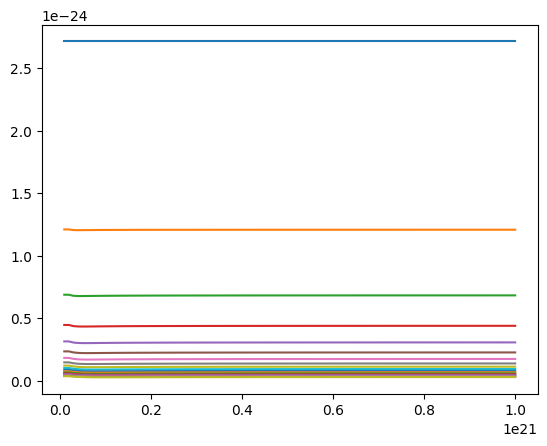

In [85]:
fig, ax = plt.subplots()
draw_time_zero = 1
draw_time_step = 50
for i in range(draw_time_zero, rho.shape[0]-1, draw_time_step):
    ax.plot(r[:], rho[i, :])
plt.show()

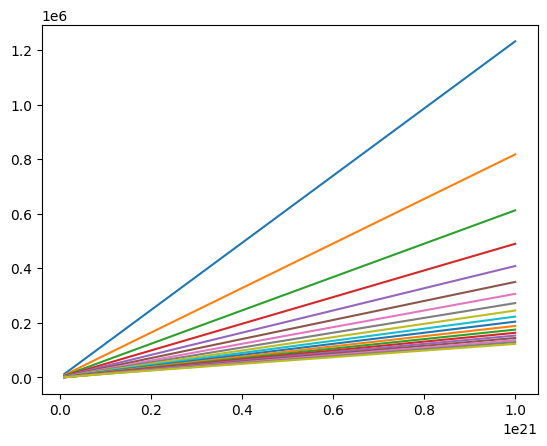

In [92]:
# Скорость
fig, ax = plt.subplots()
draw_time_zero = 0
draw_time_step = 50
for i in range(draw_time_zero, U.shape[0]-2, draw_time_step):
    ax.plot(r[:], U[i+1, :])
plt.show()

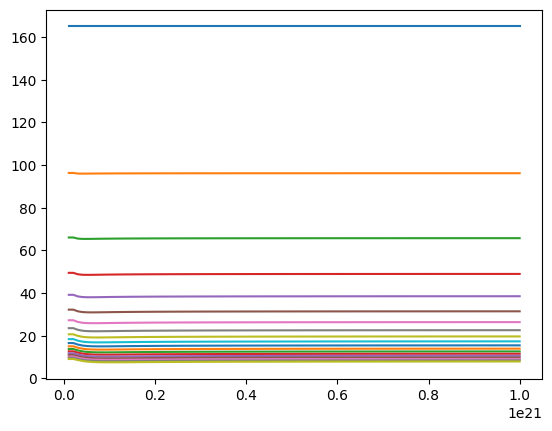

In [87]:
# Температура
fig, ax = plt.subplots()
draw_time_zero = 1
draw_time_step = 50
for i in range(draw_time_zero, T.shape[0]-1, draw_time_step):
    ax.plot(r[:], T[i, :])
plt.show()

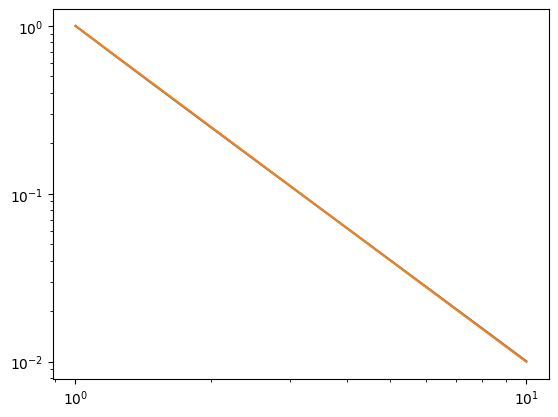

In [88]:
# Проверка плотности
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], rho[:-1, 50]/rho[0, 50])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-2)

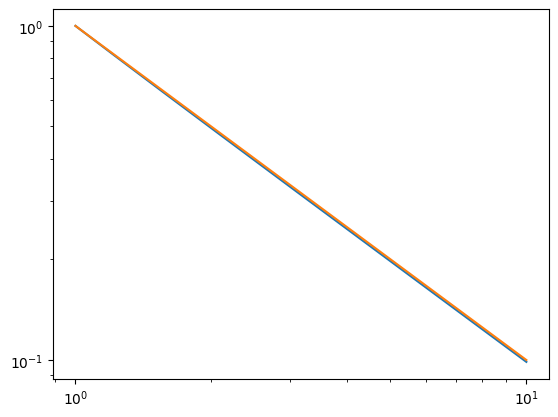

In [89]:
# Проверка скорости
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], U[:-1, -1]/U[0,-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],H*r[-1]/U[0,-1])

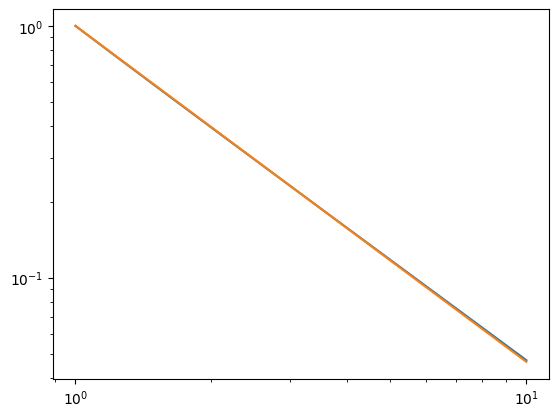

In [90]:
# Проверка температуры
fig, ax = plt.subplots()
ax.plot(t_vector/t_vector[0], T[:-1, -1]/T[0,-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(t_vector/t_vector[0],(t_vector/t_vector[0])**-(4/3))